In [2]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models

from PIL import Image 
import albumentations as A
from albumentations.pytorch import ToTensorV2

RANDOM_SEED=42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available:
    torch.cuda.manual_seed(RANDOM_SEED)

In [3]:
# Check device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if torch.cuda.is_available:
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'Memory: {torch.cuda.get_device_properties(0).total_memory/1e9:.2f}GB')

Using device: cuda
GPU: NVIDIA GeForce RTX 3050 Laptop GPU
Memory: 4.29GB


In [4]:
# Initial declaration
DATASET_PATH='../../data/food-101/food-101/images'
TRAIN_CSV='../../data/food-101/food-101-preprocessed/train_df.csv'
VAL_CSV='../../data/food-101/food-101-preprocessed/val_df.csv'
TEST_CSV='../../data/food-101/food-101-preprocessed/test_df.csv'

MODEL_NAME='resnet50'
NUM_CLASSES=101
IMG_SIZE=224   
BATCH_SIZE=16
NUM_EPOCHS=10
LEARNING_RATE=0.001
NUM_WORKERS=4

SAVE_MODEL_PATH='../../models'
SAVE_RESULTS_PATH='../../results'

In [5]:
# Augmentation
train_transform=A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.3),
    A.Affine(translate_percent={'x':0.1, 'y':0.1}, scale=(0.9, 1.1), rotate=(+15, -15), p=0.3),

    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),

    A.GaussNoise(var_limit=(10, 30), p=0.3),
    A.GaussianBlur(blur_limit=(3,5), p=0.2),

    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_test_transform=A.Compose([
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

C:\Users\asus\AppData\Local\Temp\ipykernel_36224\731977300.py:10: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10, 30), p=0.3),


In [6]:
# PyTorch Dataset objects
class Food101Dataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.df=pd.read_csv(csv_file)
        self.root_dir=root_dir
        self.transform=transform

        self.classes=sorted(self.df['class_name'].unique())
        self.cls_to_idx={cls: idx for idx, cls in enumerate(self.classes)} # Encode
        self.idx_to_cls={idx: cls for idx, cls in enumerate(self.classes)} # Decode

        print(f'Dataset loaded: {len(self.df)} images, {len(self.classes)} classes.')

    def __len__(self):
        return(len(self.df))
    
    def __getitem__(self, idx):
        img_path=self.df.iloc[idx]['image_path']
        img=Image.open(img_path).convert('RGB')
        img=img.resize((IMG_SIZE, IMG_SIZE))
        img=np.array(img)

        class_name=self.df.iloc[idx]['class_name'] 

        label=self.cls_to_idx[class_name]

        if self.transform: # Transform image from NumPy arrays to PyTorch tensor
            transformed=self.transform(image=img)
            img=transformed['image']

        return img, label
    
    def get_class_name(self, idx):
        return self.idx_to_cls[idx]

Dataset loaded: 70700 images, 101 classes.
Dataset loaded: 15150 images, 101 classes.
Dataset loaded: 15150 images, 101 classes.

Data loading test
Image batch shape: torch.Size([16, 3, 224, 224])
Labels shape: torch.Size([16])


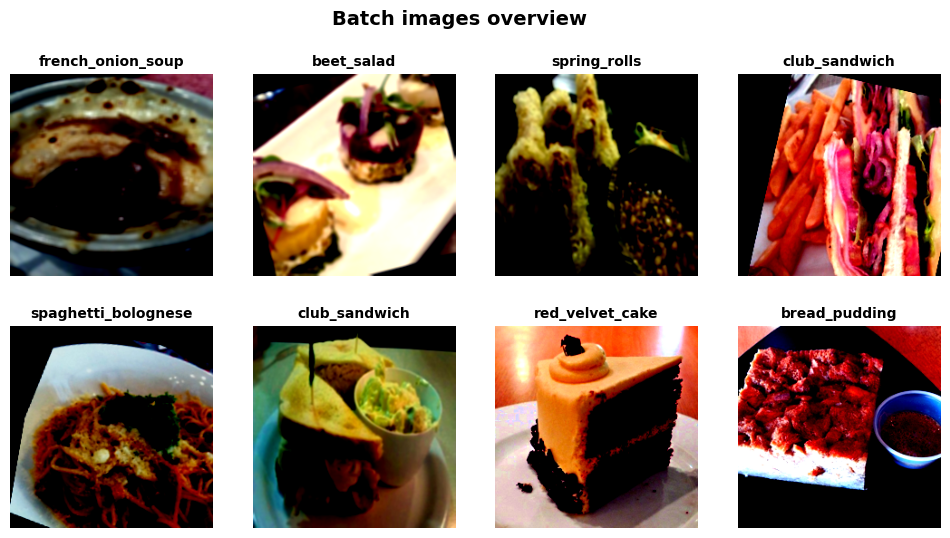

In [7]:
# Dataset objects
train_dataset=Food101Dataset(
    csv_file=TRAIN_CSV,
    root_dir='',
    transform=train_transform
)

val_dataset=Food101Dataset(
    csv_file=VAL_CSV,
    root_dir='',
    transform=val_test_transform
)

test_dataset=Food101Dataset(
    csv_file=TEST_CSV,
    root_dir='',
    transform=val_test_transform
)

# DataLoaders
train_loader=DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

val_loader=DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False, 
    num_workers=0,
    pin_memory=True
)

test_loader=DataLoader(
    dataset=test_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=False, 
    num_workers=0,
    pin_memory=True
)

print(f'\nData loading test')
batches, labels=next(iter(train_loader))
print(f'Image batch shape: {batches.shape}')
print(f'Labels shape: {labels.shape}')

# Batch viz
fig, ax=plt.subplots(2, 4, figsize=(12, 6))
ax=ax.flatten()

mean=np.array([0.485, 0.456, 0.406])
std=np.array([0.229, 0.224, 0.225])

for i in range(8):
    img=batches[i].permute(1, 2, 0).cpu().numpy()
    img=img * mean + std
    img=np.clip(img, 0, 1)

    ax[i].imshow(img)
    class_name=train_dataset.get_class_name(labels[i].item())
    ax[i].set_title(f'{class_name}', fontsize=10, fontweight='bold')
    ax[i].axis('off')

plt.suptitle('Batch images overview', fontsize=14, fontweight='bold')
plt.savefig('figures/batch_images_sample', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
# Model definition
def build_model(model_name='resnet50', num_classes=101, pretrained=True):

    if model_name=='resnet50':
        if pretrained:
            model=models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        else:
            model=models.resnet50(weights=None)
        num_features=model.fc.in_features
        model.fc=nn.Linear(num_features, num_classes)
    elif model_name=='efficientnet_b0':
        if pretrained:
            model=models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        else:
            model=models.efficientnet_b0(weights=None)
        num_features=model.fc.in_features
        model.classifier[1]=nn.Linear(num_features, num_classes)
    elif model_name=='mobilenet_v2':
        if pretrained:
            model=models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V2)
        else:
            model=models.mobilenet_v2(weights=None)
        num_features=model.fc.in_features
        model.classifier[1]=nn.Linear(num_features, num_classes)

    else:
        raise ValueError(f'Unknown model: {model_name}')
    
    return model

model=build_model(MODEL_NAME, NUM_CLASSES, pretrained=True)
model=model.to(device) 

# Parameters info
total_params=sum(p.numel() for p in model.parameters())
trainable_params=sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Parameter overview')
print(f'Total parameters: {total_params}')
print(f'Trainable parameters: {trainable_params}')
print(f'Model location: {next(model.parameters()).device}')

Parameter overview
Total parameters: 23714981
Trainable parameters: 23714981
Model location: cuda:0


In [ ]:
# Loss function and optimizer
criterion=nn.CrossEntropyLoss()

optimizer=optim.Adam(model.parameters(), lr=LEARNING_RATE)
validate_modelcannot unpack non-iterable NoneType object
scheduler=optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=2,
    verbose=True
)

d:\work\me-food\venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [10]:
# Training functions
def train_one_epoch(model, loader, criterion, optimizer, device): 
    model.train()
    running_loss=0.0
    correct=0
    total=0

    pbar=tqdm.tqdm(loader, desc='Training')
    for images, labels, in pbar:
        images, labels=images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs=model(images) # Forward pass
        loss=criterion(outputs, labels)

        loss.backward() # Backward pass
        optimizer.step()

        running_loss+=loss.item() 
        _, predicted=outputs.max(1)
        correct+=predicted.eq(labels).sum().item()
        total+=labels.size(0)

        pbar.set_postfix({
            'loss': f'{running_loss/len(loader):.2f}',
            'acc': f'{100.*correct/total:.2f}%'
        }) 

    epoch_loss=running_loss/len(loader)
    epoch_acc=100.*correct/total
    
    return epoch_loss, epoch_acc

# Validation functio
def validate_model(model, loader, criterion, device):
    model.eval()
    running_loss=0.0
    correct=0
    total=0

    with torch.no_grad():
        pbar=tqdm.tqdm(loader, desc='Validating')
        for images, labels in pbar:
            images, labels=images.to(device), labels.to(device)

            outputs=model(images)
            loss=criterion(outputs, labels)

            running_loss+=loss.item()
            _, predicted=outputs.max(1) 
            correct+=predicted.eq(labels).sum().item()
            total+=labels.size(0)
            
            pbar.set_postfix({
                'loss': f'{running_loss/len(loader):.2f}',
                'acc': f'{100.*correct/total:.2f}%'
            })

    epoch_loss=running_loss/len(loader)
    epoch_acc=100.*correct/total

    return epoch_loss, epoch_acc 

In [11]:
# Model training
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc = 0.0
best_epoch = 0

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch [{epoch+1}/{NUM_EPOCHS}]")

    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)

    val_loss, val_acc = validate_model(model, val_loader, criterion, device)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    scheduler.step(val_acc)

    print(f"Epoch {epoch+1} Summary:")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
        }, f'{SAVE_MODEL_PATH}/best_model.pth')
        print(f"Best model: Val Acc: {val_acc:.2f}%)")

print(f"Best validation accuracy: {best_val_acc:.2f}% (Epoch {best_epoch})")

# Save training history
with open(f'{SAVE_RESULTS_PATH}/training_history.json', 'w') as f:
    json.dump(history, f, indent=2)


Epoch [1/10]


Validating: 100%|██████████| 947/947 [04:23<00:00,  3.59it/s, loss=3.93, acc=9.72%] 


Epoch 1 Summary:
Train Loss: 4.3731 | Train Acc: 3.94%
Val Loss: 3.9314 | Val Acc: 9.72%
Best model: Val Acc: 9.72%)

Epoch [2/10]


Validating: 100%|██████████| 947/947 [01:43<00:00,  9.19it/s, loss=3.23, acc=22.53%]


Epoch 2 Summary:
Train Loss: 3.7309 | Train Acc: 13.46%
Val Loss: 3.2252 | Val Acc: 22.53%
Best model: Val Acc: 22.53%)

Epoch [3/10]


Validating: 100%|██████████| 947/947 [01:42<00:00,  9.22it/s, loss=2.80, acc=31.37%]


Epoch 3 Summary:
Train Loss: 3.2127 | Train Acc: 23.23%
Val Loss: 2.8043 | Val Acc: 31.37%
Best model: Val Acc: 31.37%)

Epoch [4/10]


Validating: 100%|██████████| 947/947 [01:42<00:00,  9.25it/s, loss=2.37, acc=42.06%]


Epoch 4 Summary:
Train Loss: 2.8067 | Train Acc: 31.73%
Val Loss: 2.3663 | Val Acc: 42.06%
Best model: Val Acc: 42.06%)

Epoch [5/10]


Validating: 100%|██████████| 947/947 [01:43<00:00,  9.19it/s, loss=2.10, acc=47.40%]


Epoch 5 Summary:
Train Loss: 2.4868 | Train Acc: 38.79%
Val Loss: 2.1020 | Val Acc: 47.40%
Best model: Val Acc: 47.40%)

Epoch [6/10]


Validating: 100%|██████████| 947/947 [01:42<00:00,  9.24it/s, loss=1.91, acc=51.97%]


Epoch 6 Summary:
Train Loss: 2.2219 | Train Acc: 44.11%
Val Loss: 1.9114 | Val Acc: 51.97%
Best model: Val Acc: 51.97%)

Epoch [7/10]


Validating: 100%|██████████| 947/947 [01:41<00:00,  9.31it/s, loss=1.83, acc=54.77%]


Epoch 7 Summary:
Train Loss: 2.0320 | Train Acc: 48.63%
Val Loss: 1.8257 | Val Acc: 54.77%
Best model: Val Acc: 54.77%)

Epoch [8/10]


Validating: 100%|██████████| 947/947 [06:31<00:00,  2.42it/s, loss=1.73, acc=56.65%]


Epoch 8 Summary:
Train Loss: 1.8781 | Train Acc: 52.20%
Val Loss: 1.7314 | Val Acc: 56.65%
Best model: Val Acc: 56.65%)

Epoch [9/10]


Validating: 100%|██████████| 947/947 [04:53<00:00,  3.23it/s, loss=1.70, acc=58.35%]


Epoch 9 Summary:
Train Loss: 1.7484 | Train Acc: 55.00%
Val Loss: 1.6963 | Val Acc: 58.35%
Best model: Val Acc: 58.35%)

Epoch [10/10]


Validating: 100%|██████████| 947/947 [05:52<00:00,  2.69it/s, loss=1.67, acc=58.90%]


Epoch 10 Summary:
Train Loss: 1.6285 | Train Acc: 57.65%
Val Loss: 1.6718 | Val Acc: 58.90%
Best model: Val Acc: 58.90%)
Best validation accuracy: 58.90% (Epoch 10)


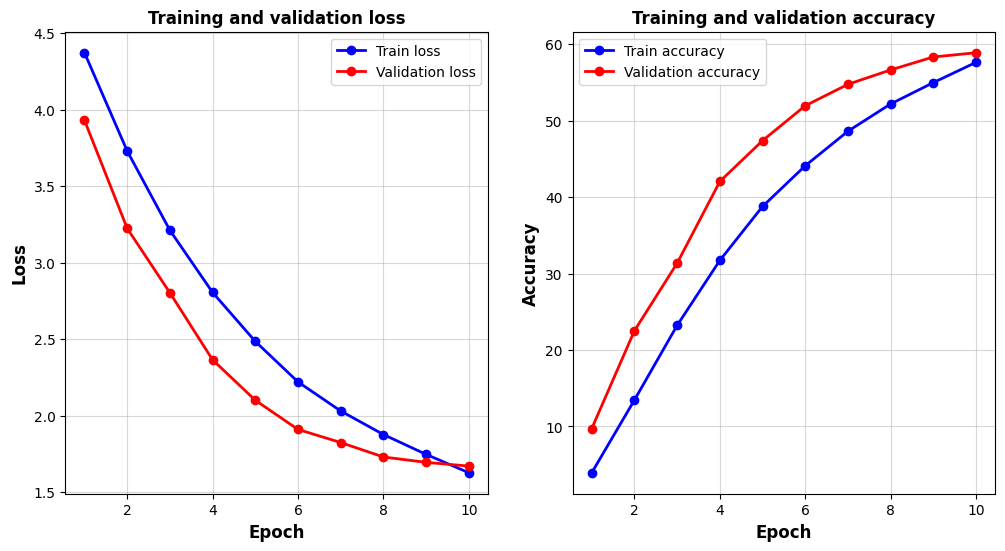

In [12]:
# Training history viz
fig, ax=plt.subplots(1, 2, figsize=(12, 6))

epochs=range(1, NUM_EPOCHS + 1)

ax[0].plot(epochs, history['train_loss'], 'b-o', label='Train loss', linewidth=2)
ax[0].plot(epochs, history['val_loss'], 'r-o', label='Validation loss', linewidth=2)
ax[0].set_xlabel(f'Epoch', fontsize=12, fontweight='bold')
ax[0].set_ylabel(f'Loss', fontsize=12, fontweight='bold')
ax[0].set_title(f'Training and validation loss', fontsize=12, fontweight='bold')
ax[0].legend()
ax[0].grid(alpha=0.5)

ax[1].plot(epochs, history['train_acc'], 'b-o', label='Train accuracy', linewidth=2)
ax[1].plot(epochs, history['val_acc'], 'r-o', label='Validation accuracy', linewidth=2)
ax[1].set_xlabel(f'Epoch', fontsize=12, fontweight='bold')
ax[1].set_ylabel(f'Accuracy', fontsize=12, fontweight='bold')
ax[1].set_title(f'Training and validation accuracy', fontsize=12, fontweight='bold')
ax[1].legend()
ax[1].grid(alpha=0.5)

plt.savefig('figures/training_history', dpi=300, bbox_inches='tight')
plt.show()